<a href="https://colab.research.google.com/github/gforconi/UTNIA2025/blob/main/Clasificador_de_im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes con PyTorch


Este notebook te guía paso a paso por el flujo de un proyecto de clasificación de imágenes con PyTorch usando el dataset CIFAR-10.  
Vas a comparar dos optimizadores populares (Adam y RMSprop), medir y graficar métricas, y aprender a interpretar y mejorar tus resultados.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

## 1. Preparación de los datos

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 77.8MB/s]


## 2. Visualización rápida del dataset

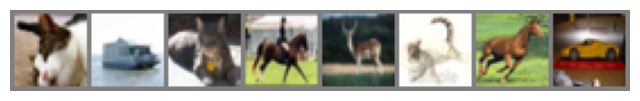

Etiquetas:   cat  ship   cat horse  deer   cat horse   car


In [4]:
def imshow(img, size=(8, 4)):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.figure(figsize=size)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))  # Aumentá el tamaño acá si querés
print('Etiquetas:', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

## 3. Definición del modelo

## ¿Qué es una CNN (Convolutional Neural Network)?

Una **CNN** (red neuronal convolucional) es un tipo de red neuronal artificial especialmente diseñada para procesar datos que tienen una estructura de “rejilla” o espacial, como las imágenes.

### ¿Cómo funciona una CNN?
- **Detecta patrones locales:** Las CNN utilizan filtros o “kernels” que se deslizan sobre la imagen para detectar patrones como bordes, texturas y formas.
- **Aprende jerarquías de características:** Las primeras capas detectan características simples (por ejemplo, líneas y bordes). Las capas más profundas combinan esas características para reconocer patrones complejos (por ejemplo, caras, objetos, etc).
- **Reduce la dimensionalidad:** Usan operaciones de *pooling* para reducir el tamaño de la representación, ayudando a generalizar y reducir el costo computacional.

### ¿Por qué son importantes?
- Las CNN son el estándar en visión por computador y clasificación de imágenes, porque pueden aprender automáticamente las mejores características a partir de los datos, sin necesidad de “ingeniería de características” manual.
- También se usan en video, audio, procesamiento de texto y otras áreas donde los datos tienen estructura local.

### Componentes clave:
- **Capas convolucionales:** Extraen características aplicando filtros.
- **Capas de pooling:** Resumen información y reducen tamaño.
- **Capas totalmente conectadas:** Deciden la clasificación final en función de las características extraídas.

---

En resumen, las **CNN** son la base de los avances modernos en reconocimiento de imágenes, siendo capaces de aprender de los datos “qué buscar” para distinguir una clase de otra.


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Explicación de la arquitectura del modelo **Net**

El modelo `Net` es una red neuronal convolucional (CNN) simple, adecuada para tareas de clasificación de imágenes.
A continuación se detalla la función y el flujo de cada capa:

---

**Estructura del modelo:**

1. **Capa Convolucional 1 (`conv1`)**
   - `nn.Conv2d(3, 6, 5)`:
   - Toma imágenes con 3 canales (RGB), produce 6 mapas de características (features) usando filtros de tamaño 5x5.
   - Ayuda a detectar patrones locales como bordes y texturas.

2. **Capa de Pooling (`pool`)**
   - `nn.MaxPool2d(2, 2)`:
   - Reduce el tamaño espacial (anchura y altura) de los mapas de características, manteniendo sólo el valor máximo en cada región 2x2.
   - Esto disminuye la cantidad de parámetros y ayuda a la red a ser invariante a pequeñas traslaciones.

3. **Capa Convolucional 2 (`conv2`)**
   - `nn.Conv2d(6, 16, 5)`:
   - Toma los 6 mapas de características de la primera convolución y aprende 16 nuevos filtros, de tamaño 5x5.

4. **Aplanamiento (`torch.flatten`)**
   - Convierte los mapas de características resultantes en un vector (flatten) para poder conectarlo a capas completamente conectadas (densas).

5. **Capa totalmente conectada 1 (`fc1`)**
   - `nn.Linear(16 * 5 * 5, 120)`:
   - Recibe el vector de características y aprende a combinarlo en 120 nuevas representaciones.

6. **Capa totalmente conectada 2 (`fc2`)**
   - `nn.Linear(120, 84)`:
   - Reduce dimensionalidad, permitiendo al modelo aprender combinaciones aún más abstractas.

7. **Capa de salida (`fc3`)**
   - `nn.Linear(84, 10)`:
   - Produce un vector de 10 valores (uno por cada clase de imagen).
   - La clase predicha será la de mayor valor (luego de aplicar softmax implícitamente en la función de pérdida).

---

**Activaciones y flujo de datos (forward):**
- Después de cada convolución se aplica la función de activación ReLU (`torch.relu`) para introducir no linealidad.
- Tras cada convolución, se aplica pooling para reducción de dimensión.
- Después del aplanado, los datos pasan por las capas totalmente conectadas con ReLU entre cada una, hasta llegar a la salida final.

---

**Resumen:**  
Este modelo es una versión básica de una CNN, lo que la hace fácil de interpretar y entrenar rápidamente en datasets pequeños como CIFAR-10, aunque para tareas más complejas se suelen usar modelos más profundos y sofisticados.


## 4. Función de entrenamiento y validación (con registro de métricas)

Se registran: loss y accuracy en entrenamiento y validación.
Se guarda el mejor modelo según accuracy en validación.

In [7]:
def train_and_validate(optimizer_name, num_epochs=10):
    print(f"\n===> Entrenando con {optimizer_name}...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=0.001)
    else:
        raise ValueError("Solo se permite Adam o RMSprop.")

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        # --- Entrenamiento ---
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validación ---
        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        # torch.no_grad() le indica a PyTorch que no calcule ni almacene
        # los gradientes durante las operaciones que se realicen dentro de él.
        # Como vamos a evaluar en validacion no es necesario guardar los gradientes
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss = val_loss / total
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = net.state_dict()

        print(f"Época {epoch+1}: Train loss={train_loss:.4f}, Train acc={train_acc:.2f}%, Val loss={val_loss:.4f}, Val acc={val_acc:.2f}%")

    net.load_state_dict(best_model_wts)
    return train_losses, train_accuracies, val_losses, val_accuracies, net

## 5. Entrenamiento y comparación de Adam vs RMSprop

In [8]:
adam_hist = train_and_validate('Adam', num_epochs=10)
rmsprop_hist = train_and_validate('RMSprop', num_epochs=10)


===> Entrenando con Adam...
Época 1: Train loss=1.6401, Train acc=39.58%, Val loss=1.4464, Val acc=47.01%
Época 2: Train loss=1.3634, Train acc=50.41%, Val loss=1.3062, Val acc=52.71%
Época 3: Train loss=1.2497, Train acc=54.85%, Val loss=1.2520, Val acc=54.77%
Época 4: Train loss=1.1703, Train acc=57.83%, Val loss=1.1857, Val acc=57.53%
Época 5: Train loss=1.1047, Train acc=60.46%, Val loss=1.1339, Val acc=59.56%
Época 6: Train loss=1.0572, Train acc=62.49%, Val loss=1.1148, Val acc=60.51%
Época 7: Train loss=1.0077, Train acc=64.06%, Val loss=1.0948, Val acc=61.34%
Época 8: Train loss=0.9684, Train acc=65.68%, Val loss=1.1068, Val acc=61.62%
Época 9: Train loss=0.9350, Train acc=66.76%, Val loss=1.0785, Val acc=62.09%
Época 10: Train loss=0.9023, Train acc=68.01%, Val loss=1.0622, Val acc=63.53%

===> Entrenando con RMSprop...
Época 1: Train loss=1.6122, Train acc=40.53%, Val loss=1.5056, Val acc=45.51%
Época 2: Train loss=1.3203, Train acc=52.33%, Val loss=1.3565, Val acc=51.69%
Ép

## 6. Gráficas de métricas (Loss y Accuracy)

## Loss (Función de Pérdida)

Es una medida numérica de qué tan mal están las predicciones de tu modelo en comparación con los valores verdaderos. Es el valor que tu modelo intenta minimizar durante el entrenamiento.

- Si la loss es alta, significa que el modelo se está equivocando mucho.

- Si la loss es baja, el modelo está acertando más.

- La loss se calcula sumando el “costo” de cada error cometido sobre todo el batch de datos.

## Accuracy (Precisión)

Es el porcentaje de ejemplos correctamente clasificados por el modelo sobre el total de ejemplos evaluados.

- Es el número de **aciertos** dividido el número total de casos.
- Se expresa como porcentaje (%) o decimal (ejemplo: 0.85 = 85%).

**Fórmula:**  

$$
\text{accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}}
$$

**¿Por qué es importante?**  
La accuracy es la métrica más directa para medir el desempeño en tareas de clasificación balanceadas.  
Sin embargo, en problemas con clases desbalanceadas, se recomienda complementarla con métricas como F1-score o matriz de confusión para un diagnóstico más completo.



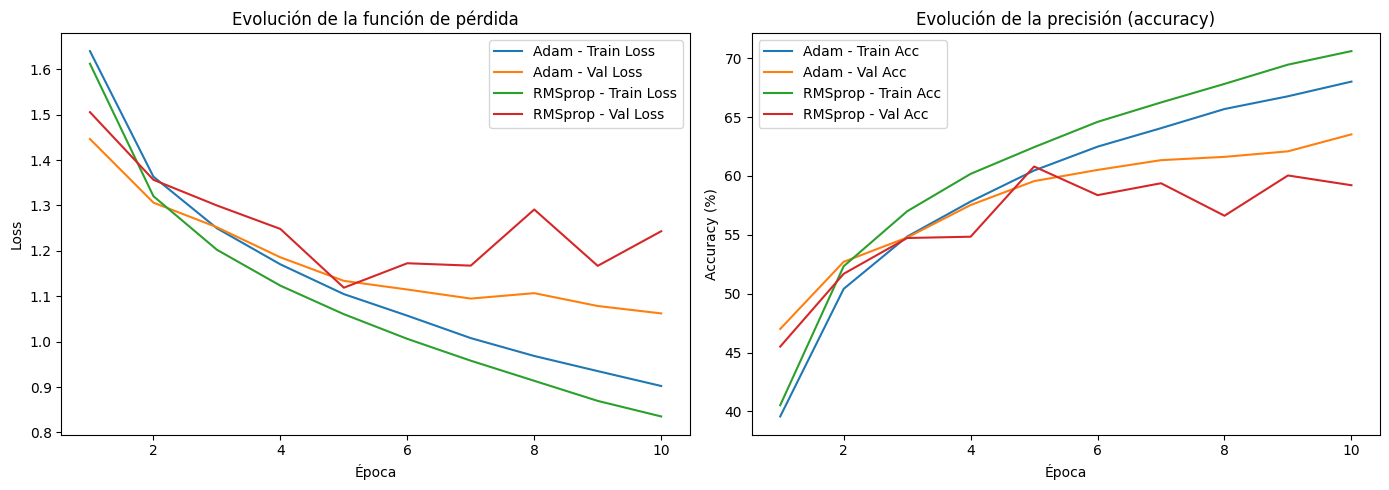

In [9]:
epochs = range(1, 11)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, adam_hist[0], label='Adam - Train Loss')
plt.plot(epochs, adam_hist[2], label='Adam - Val Loss')
plt.plot(epochs, rmsprop_hist[0], label='RMSprop - Train Loss')
plt.plot(epochs, rmsprop_hist[2], label='RMSprop - Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolución de la función de pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, adam_hist[1], label='Adam - Train Acc')
plt.plot(epochs, adam_hist[3], label='Adam - Val Acc')
plt.plot(epochs, rmsprop_hist[1], label='RMSprop - Train Acc')
plt.plot(epochs, rmsprop_hist[3], label='RMSprop - Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.title('Evolución de la precisión (accuracy)')
plt.legend()

plt.tight_layout()
plt.show()

## Interpretación de las gráficas de entrenamiento y validación

### Evolución de la función de pérdida (Loss)
- **Ambos optimizadores (Adam y RMSprop) logran una disminución progresiva de la loss de entrenamiento y validación a lo largo de las épocas.**
- Las curvas de **loss de entrenamiento** (líneas azul y verde) bajan de manera bastante continua y suave, mostrando que ambos modelos están aprendiendo a minimizar el error sobre los datos de entrenamiento.
- En **loss de validación** (líneas naranja y roja), la curva de Adam se mantiene más estable y baja que la de RMSprop, especialmente a partir de la 4ta época. La curva de RMSprop-Val Loss muestra más oscilaciones, lo cual indica que sus predicciones en datos no vistos son menos consistentes y el modelo podría estar sufriendo cierta inestabilidad o sobreajuste.
- Si bien ambas losses de validación bajan al principio, la de RMSprop presenta mayores picos, lo cual suele indicar que el modelo tiene más dificultad para generalizar fuera del set de entrenamiento.

### Evolución de la precisión (Accuracy)
- Tanto Adam como RMSprop muestran un incremento claro de **accuracy de entrenamiento** (líneas azul y verde), alcanzando valores cercanos al 70% al final de las 10 épocas.
- En **accuracy de validación** (líneas naranja y roja), Adam logra una mejora más progresiva y consistente, mientras que RMSprop presenta más altibajos y se queda por debajo del performance de Adam en la mayoría de las épocas.
- El mejor accuracy de validación lo consigue Adam, lo cual indica que es más efectivo para generalizar en este caso.
- Las diferencias entre train y val accuracy para ambos optimizadores no son extremas, lo cual sugiere que el modelo aún no está sobreajustando de forma severa, pero la mayor variabilidad de RMSprop en validación sugiere menor estabilidad.

### Resumen y conclusiones
- **Adam** muestra mejor comportamiento general tanto en loss como en accuracy, especialmente en los datos de validación (test).
- **RMSprop** tiende a ser más inestable en validación, con más fluctuaciones y menor precisión máxima.
- Si tuvieras que elegir un optimizador en este contexto, **Adam sería preferible** por su estabilidad y mejor generalización observada.

> **Consejo:** Podrías intentar entrenar por más épocas, aplicar early stopping, o probar técnicas de regularización si ves que la diferencia entre entrenamiento y validación se hace muy grande en el futuro.





## 7. F1-score y Matriz de Confusión (Adam)

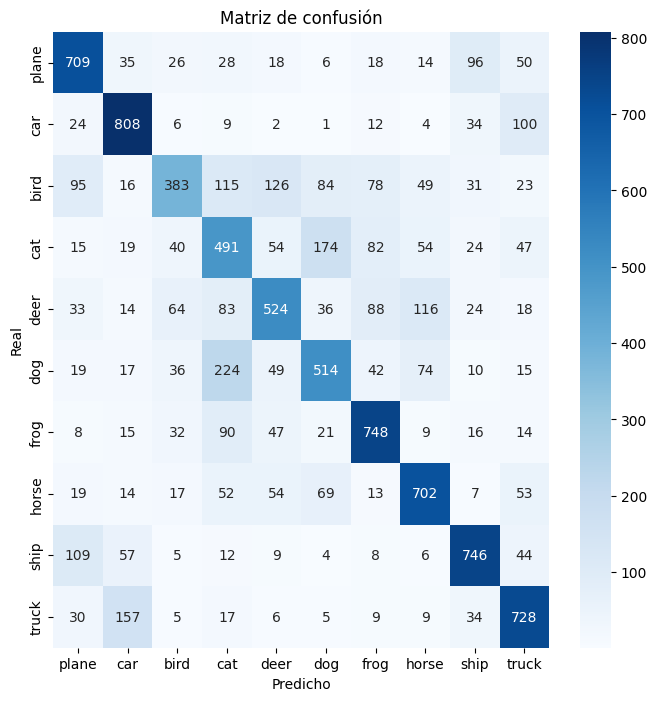

              precision    recall  f1-score   support

       plane       0.67      0.71      0.69      1000
         car       0.70      0.81      0.75      1000
        bird       0.62      0.38      0.47      1000
         cat       0.44      0.49      0.46      1000
        deer       0.59      0.52      0.55      1000
         dog       0.56      0.51      0.54      1000
        frog       0.68      0.75      0.71      1000
       horse       0.68      0.70      0.69      1000
        ship       0.73      0.75      0.74      1000
       truck       0.67      0.73      0.70      1000

    accuracy                           0.64     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.63      0.64      0.63     10000



In [10]:
# Usamos el mejor modelo Adam para calcular métricas avanzadas
model = adam_hist[4].eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

## 8. Interpretación de métricas y gráficas

**Interpretando las gráficas:**
- Si la loss de entrenamiento y validación bajan y accuracy sube, ¡tu red está aprendiendo!
- Si la loss de entrenamiento sigue bajando pero la de validación sube, es probable que estés sobreajustando (*overfitting*).
- Si la accuracy de validación se estanca o disminuye, considera técnicas como *early stopping*, regularización, o aumentar datos.

**Sobre la matriz de confusión y F1-score:**
- La matriz de confusión te muestra en qué clases tu modelo confunde más.
- El F1-score es una métrica que combina precisión y recall en un solo número. Es especialmente útil cuando las clases están desbalanceadas (hay más ejemplos de una clase que de otra).

- **Precisión (precision):**
¿De todas las veces que el modelo dijo “esto es un gato”, cuántas veces fue verdad? **precision = TP / (TP + FP)**

- **Recall (sensibilidad):**
¿De todos los verdaderos “gatos”, cuántos encontró el modelo? **recall = TP / (TP + FN)**

- **F1-score:** Es la media armónica de precisión y recall. **F1 = 2 × (precision × recall) / (precision + recall)**

Si el F1 es 1, es perfecto; si es 0, es pésimo.
Ventaja: penaliza cuando una de las dos (precisión o recall) es muy baja.

**¿Cómo elegir el número óptimo de épocas?**
- No existe un número mágico: lo óptimo es donde la loss de validación ya no mejora (o comienza a empeorar).
- Puedes usar *early stopping*: dejar de entrenar si la métrica de validación no mejora por N épocas.
- Observa las gráficas: busca el punto donde la mejora se hace marginal.